In [1]:
import numpy as np 
import random
import matplotlib.pyplot as plt # Graphical library
from sklearn.metrics import mean_squared_error # Mean-squared error function

# Coursework 1 :
See pdf for instructions. 

In [2]:
# WARNING: fill in these two functions that will be used by the auto-marking script

def get_CID():
  return "02069144" # Return your CID (add 0 at the beginning to ensure it is 8 digits long)

def get_login():
  return "ls1121" # Return your short imperial login

## Helper class

In [3]:
# This class is used ONLY for graphics
# YOU DO NOT NEED to understand it to work on this coursework

class GraphicsMaze(object):

  def __init__(self, shape, locations, default_reward, obstacle_locs, absorbing_locs, absorbing_rewards, absorbing):

    self.shape = shape
    self.locations = locations
    self.absorbing = absorbing

    # Walls
    self.walls = np.zeros(self.shape)
    for ob in obstacle_locs:
      self.walls[ob] = 20

    # Rewards
    self.rewarders = np.ones(self.shape) * default_reward
    for i, rew in enumerate(absorbing_locs):
      self.rewarders[rew] = 10 if absorbing_rewards[i] > 0 else -10

    # Print the map to show it
    self.paint_maps()

  def paint_maps(self):
    """
    Print the Maze topology (obstacles, absorbing states and rewards)
    input: /
    output: /
    """
    plt.figure(figsize=(15,10))
    plt.imshow(self.walls + self.rewarders)
    plt.show()

  def paint_state(self, state):
    """
    Print one state on the Maze topology (obstacles, absorbing states and rewards)
    input: /
    output: /
    """
    states = np.zeros(self.shape)
    states[state] = 30
    plt.figure(figsize=(15,10))
    plt.imshow(self.walls + self.rewarders + states)
    plt.show()

  def draw_deterministic_policy(self, Policy):
    """
    Draw a deterministic policy
    input: Policy {np.array} -- policy to draw (should be an array of values between 0 and 3 (actions))
    output: /
    """
    plt.figure(figsize=(15,10))
    plt.imshow(self.walls + self.rewarders) # Create the graph of the Maze
    for state, action in enumerate(Policy):
      if(self.absorbing[0,state]): # If it is an absorbing state, don't plot any action
        continue
      arrows = [r"$\uparrow$",r"$\rightarrow$", r"$\downarrow$", r"$\leftarrow$"] # List of arrows corresponding to each possible action
      action_arrow = arrows[action] # Take the corresponding action
      location = self.locations[state] # Compute its location on graph
      plt.text(location[1], location[0], action_arrow, ha='center', va='center') # Place it on graph
    plt.show()

  def draw_policy(self, Policy):
    """
    Draw a policy (draw an arrow in the most probable direction)
    input: Policy {np.array} -- policy to draw as probability
    output: /
    """
    deterministic_policy = np.array([np.argmax(Policy[row,:]) for row in range(Policy.shape[0])])
    self.draw_deterministic_policy(deterministic_policy)

  def draw_value(self, Value):
    """
    Draw a policy value
    input: Value {np.array} -- policy values to draw
    output: /
    """
    plt.figure(figsize=(15,10))
    plt.imshow(self.walls + self.rewarders) # Create the graph of the Maze
    for state, value in enumerate(Value):
      if(self.absorbing[0, state]): # If it is an absorbing state, don't plot any value
        continue
      location = self.locations[state] # Compute the value location on graph
      plt.text(location[1], location[0], round(value,2), ha='center', va='center') # Place it on graph
    plt.show()

  def draw_deterministic_policy_grid(self, Policies, title, n_columns, n_lines):
    """
    Draw a grid representing multiple deterministic policies
    input: Policies {np.array of np.array} -- array of policies to draw (each should be an array of values between 0 and 3 (actions))
    output: /
    """
    plt.figure(figsize=(20,8))
    for subplot in range (len(Policies)): # Go through all policies
      ax = plt.subplot(n_columns, n_lines, subplot+1) # Create a subplot for each policy
      ax.imshow(self.walls+self.rewarders) # Create the graph of the Maze
      for state, action in enumerate(Policies[subplot]):
        if(self.absorbing[0,state]): # If it is an absorbing state, don't plot any action
          continue
        arrows = [r"$\uparrow$",r"$\rightarrow$", r"$\downarrow$", r"$\leftarrow$"] # List of arrows corresponding to each possible action
        action_arrow = arrows[action] # Take the corresponding action
        location = self.locations[state] # Compute its location on graph
        plt.text(location[1], location[0], action_arrow, ha='center', va='center') # Place it on graph
      ax.title.set_text(title[subplot]) # Set the title for the graph given as argument
    plt.show()

  def draw_policy_grid(self, Policies, title, n_columns, n_lines):
    """
    Draw a grid representing multiple policies (draw an arrow in the most probable direction)
    input: Policy {np.array} -- array of policies to draw as probability
    output: /
    """
    deterministic_policies = np.array([[np.argmax(Policy[row,:]) for row in range(Policy.shape[0])] for Policy in Policies])
    self.draw_deterministic_policy_grid(deterministic_policies, title, n_columns, n_lines)

  def draw_value_grid(self, Values, title, n_columns, n_lines):
    """
    Draw a grid representing multiple policy values
    input: Values {np.array of np.array} -- array of policy values to draw
    output: /
    """
    plt.figure(figsize=(20,8))
    for subplot in range (len(Values)): # Go through all values
      ax = plt.subplot(n_columns, n_lines, subplot+1) # Create a subplot for each value
      ax.imshow(self.walls+self.rewarders) # Create the graph of the Maze
      for state, value in enumerate(Values[subplot]):
        if(self.absorbing[0,state]): # If it is an absorbing state, don't plot any value
          continue
        location = self.locations[state] # Compute the value location on graph
        plt.text(location[1], location[0], round(value,1), ha='center', va='center') # Place it on graph
      ax.title.set_text(title[subplot]) # Set the title for the graoh given as argument
    plt.show()


## Maze class

In [4]:
# This class define the Maze environment

class Maze(object):

  def __init__(self):
    """
    Maze initialisation.
    input: /
    output: /
    """
    # Properties set from the CID
    y = int(get_CID()[-2])
    z = int(get_CID()[-1])
    self._prob_success = 0.8 + 0.02 * (9 - y) # float
    self._gamma = 0.8 + 0.02 * y # float
    self._goal = z%4 # integer (0 for R0, 1 for R1, 2 for R2, 3 for R3)

    # Build the maze
    self._build_maze()

  # Functions used to build the Maze environment 
  # You DO NOT NEED to modify them
  def _build_maze(self):
    """
    Maze initialisation.
    input: /
    output: /
    """

    # Properties of the maze
    self._shape = (13, 10)
    self._obstacle_locs = [
                          (1,0), (1,1), (1,2), (1,3), (1,4), (1,7), (1,8), (1,9), \
                          (2,1), (2,2), (2,3), (2,7), \
                          (3,1), (3,2), (3,3), (3,7), \
                          (4,1), (4,7), \
                          (5,1), (5,7), \
                          (6,5), (6,6), (6,7), \
                          (8,0), \
                          (9,0), (9,1), (9,2), (9,6), (9,7), (9,8), (9,9), \
                          (10,0)
                         ] # Location of obstacles
    self._absorbing_locs = [(2,0), (2,9), (10,1), (12,9)] # Location of absorbing states
    self._absorbing_rewards = [ (500 if (i == self._goal) else -50) for i in range (4) ] # Reward of absorbing states
    self._starting_locs = [(0,0), (0,1), (0,2), (0,3), (0,4), (0,5), (0,6), (0,7), (0,8), (0,9)] 
    self._default_reward = -1 # Reward for each action performs in the environment
    self._max_t = 500 # Max number of steps in the environment

    # Actions
    self._action_size = 4
    self._direction_names = ['N','E','S','W'] # Direction 0 is 'N', 1 is 'E' and so on
        
    # States
    self._locations = []
    for i in range (self._shape[0]):
      for j in range (self._shape[1]):
        loc = (i,j) 
        # Adding the state to locations if it is no obstacle
        if self._is_location(loc):
          self._locations.append(loc)
    self._state_size = len(self._locations)

    # Neighbours - each line is a state, ranked by state-number, each column is a direction (N, E, S, W)
    self._neighbours = np.zeros((self._state_size, 4)) 
    
    for state in range(self._state_size):
      loc = self._get_loc_from_state(state)

      # North
      neighbour = (loc[0]-1, loc[1]) # North neighbours location
      if self._is_location(neighbour):
        self._neighbours[state][self._direction_names.index('N')] = self._get_state_from_loc(neighbour)
      else: # If there is no neighbour in this direction, coming back to current state
        self._neighbours[state][self._direction_names.index('N')] = state

      # East
      neighbour = (loc[0], loc[1]+1) # East neighbours location
      if self._is_location(neighbour):
        self._neighbours[state][self._direction_names.index('E')] = self._get_state_from_loc(neighbour)
      else: # If there is no neighbour in this direction, coming back to current state
        self._neighbours[state][self._direction_names.index('E')] = state

      # South
      neighbour = (loc[0]+1, loc[1]) # South neighbours location
      if self._is_location(neighbour):
        self._neighbours[state][self._direction_names.index('S')] = self._get_state_from_loc(neighbour)
      else: # If there is no neighbour in this direction, coming back to current state
        self._neighbours[state][self._direction_names.index('S')] = state

      # West
      neighbour = (loc[0], loc[1]-1) # West neighbours location
      if self._is_location(neighbour):
        self._neighbours[state][self._direction_names.index('W')] = self._get_state_from_loc(neighbour)
      else: # If there is no neighbour in this direction, coming back to current state
        self._neighbours[state][self._direction_names.index('W')] = state

    # Absorbing
    self._absorbing = np.zeros((1, self._state_size))
    for a in self._absorbing_locs:
      absorbing_state = self._get_state_from_loc(a)
      self._absorbing[0, absorbing_state] = 1

    # Transition matrix
    self._T = np.zeros((self._state_size, self._state_size, self._action_size)) # Empty matrix of domension S*S*A
    for action in range(self._action_size):
      for outcome in range(4): # For each direction (N, E, S, W)
        # The agent has prob_success probability to go in the correct direction
        if action == outcome:
          prob = 1 - 3.0 * ((1.0 - self._prob_success) / 3.0) # (theoritically equal to self.prob_success but avoid rounding error and garanty a sum of 1)
        # Equal probability to go into one of the other directions
        else:
          prob = (1.0 - self._prob_success) / 3.0
          
        # Write this probability in the transition matrix
        for prior_state in range(self._state_size):
          # If absorbing state, probability of 0 to go to any other states
          if not self._absorbing[0, prior_state]:
            post_state = self._neighbours[prior_state, outcome] # Post state number
            post_state = int(post_state) # Transform in integer to avoid error
            self._T[prior_state, post_state, action] += prob

    # Reward matrix
    self._R = np.ones((self._state_size, self._state_size, self._action_size)) # Matrix filled with 1
    self._R = self._default_reward * self._R # Set default_reward everywhere
    for i in range(len(self._absorbing_rewards)): # Set absorbing states rewards
      post_state = self._get_state_from_loc(self._absorbing_locs[i])
      self._R[:,post_state,:] = self._absorbing_rewards[i]

    # Creating the graphical Maze world
    self._graphics = GraphicsMaze(self._shape, self._locations, self._default_reward, self._obstacle_locs, self._absorbing_locs, self._absorbing_rewards, self._absorbing)
    
    # Reset the environment
    self.reset()


  def _is_location(self, loc):
    """
    Is the location a valid state (not out of Maze and not an obstacle)
    input: loc {tuple} -- location of the state
    output: _ {bool} -- is the location a valid state
    """
    if (loc[0] < 0 or loc[1] < 0 or loc[0] > self._shape[0]-1 or loc[1] > self._shape[1]-1):
      return False
    elif (loc in self._obstacle_locs):
      return False
    else:
      return True


  def _get_state_from_loc(self, loc):
    """
    Get the state number corresponding to a given location
    input: loc {tuple} -- location of the state
    output: index {int} -- corresponding state number
    """
    return self._locations.index(tuple(loc))


  def _get_loc_from_state(self, state):
    """
    Get the state number corresponding to a given location
    input: index {int} -- state number
    output: loc {tuple} -- corresponding location
    """
    return self._locations[state]

  # Getter functions used only for DP agents
  # You DO NOT NEED to modify them
  def get_T(self):
    return self._T

  def get_R(self):
    return self._R

  def get_absorbing(self):
    return self._absorbing

  # Getter functions used for DP, MC and TD agents
  # You DO NOT NEED to modify them
  def get_graphics(self):
    return self._graphics

  def get_action_size(self):
    return self._action_size

  def get_state_size(self):
    return self._state_size

  def get_gamma(self):
    return self._gamma

  # Functions used to perform episodes in the Maze environment
  def reset(self):
    """
    Reset the environment state to one of the possible starting states
    input: /
    output: 
      - t {int} -- current timestep
      - state {int} -- current state of the envionment
      - reward {int} -- current reward
      - done {bool} -- True if reach a terminal state / 0 otherwise
    """
    self._t = 0
    self._state = self._get_state_from_loc(self._starting_locs[random.randrange(len(self._starting_locs))])
    self._reward = 0
    self._done = False
    return self._t, self._state, self._reward, self._done

  def step(self, action):
    """
    Perform an action in the environment
    input: action {int} -- action to perform
    output: 
      - t {int} -- current timestep
      - state {int} -- current state of the envionment
      - reward {int} -- current reward
      - done {bool} -- True if reach a terminal state / 0 otherwise
    """

    # If environment already finished, print an error
    if self._done or self._absorbing[0, self._state]:
      print("Please reset the environment")
      return self._t, self._state, self._reward, self._done

    # Drawing a random number used for probaility of next state
    probability_success = random.uniform(0,1)

    # Look for the first possible next states (so get a reachable state even if probability_success = 0)
    new_state = 0
    while self._T[self._state, new_state, action] == 0: 
      new_state += 1
    assert self._T[self._state, new_state, action] != 0, "Selected initial state should be probability 0, something might be wrong in the environment."

    # Find the first state for which probability of occurence matches the random value
    total_probability = self._T[self._state, new_state, action]
    while (total_probability < probability_success) and (new_state < self._state_size-1):
     new_state += 1
     total_probability += self._T[self._state, new_state, action]
    assert self._T[self._state, new_state, action] != 0, "Selected state should be probability 0, something might be wrong in the environment."
    
    # Setting new t, state, reward and done
    self._t += 1
    self._reward = self._R[self._state, new_state, action]
    self._done = self._absorbing[0, new_state] or self._t > self._max_t
    self._state = new_state
    return self._t, self._state, self._reward, self._done

## DP Agent

In [5]:
class DP_agent(object):

  # WARNING: make sure this function can be called by the auto-marking script

  def policy_evaluation(self, policy, env, threshold = 0.0001):
    """
    Policy evaluation on maze
    input: 
      - policy {np.array} -- policy to evaluate
      - env {Maze object} -- Maze to solve
      - threshold {float} -- threshold value used to stop the policy evaluation algorithm
    output: 
      - V {np.array} -- value function corresponding to the policy 
      - epochs {int} -- number of iterations to evalualte policy
    """

    action_size = env.get_action_size()
    state_size = env.get_state_size()
    gamma = env.get_gamma()
    T = env.get_T()
    R = env.get_R()
    epochs = 0

    # Ensure inputs are valid
    assert (policy.shape[0] == state_size) and (policy.shape[1] == action_size), "The dimensions of the policy are not valid."
    assert (gamma <=1) and (gamma >= 0), "Discount factor should be in [0, 1]."

    # Initialisation
    delta = 2*threshold # Ensure delta is bigger than the threshold to start the loop
    V = np.zeros(state_size) # Initialise value function to 0  

    while threshold < delta:
        delta = 0
        V_new = np.zeros(state_size)
        for s in range(state_size):
          if not env.get_absorbing()[0, s]:
            a_sum = 0 
            for a in range(action_size):
                a_sum += policy[s, a] * sum(T[s, :, a]*(R[s,:,a] + gamma*V))
            V_new[s] = a_sum
        
        delta = max(delta, max(abs(V_new-V)))
        V = V_new
        epochs += 1
        del V_new
        
    return V, epochs

  def policy_improvement(self, V, policy, env):
    """
    One iteration of policy improvement on maze
    input: 
      - V {np.array} -- value function corresponding to the policy 
      - policy {np.array} -- policy to evaluate
      - env {Maze object} -- Maze to solve
    output: 
      - policy {np.array} -- improvemed policy
      - policy_stable {Boolean} -- checks if the policy is stable
    """
    
    gamma = env.get_gamma()
    state_size = env.get_state_size()
    action_size = env.get_action_size()
    T = env.get_T()
    R = env.get_R()

    policy_stable = True

    for s in range(state_size):
        
        if not env.get_absorbing()[0, s]:
          b = policy[s, :].copy()
          action_values = []
          
          for a in range(action_size):
              action_values.append(sum(T[s, :, a]*(R[s,:,a] + gamma*V)))
          
          greedy_action = np.argmax(np.array(action_values))
          
          policy[s, :] = 0
          policy[s, greedy_action] = 1
          
          if any(b != policy[s,:]):
              policy_stable = False

    return policy, policy_stable

  def policy_iteration(self, policy, env, threshold = 0.0001):
    """
    Policy iteration
    input: 
      - policy {np.array} -- policy to evaluate
      - env {Maze object} -- Maze to solve
      - threshold {float} -- threshold value used to stop the policy evaluation algorithm
    output: 
      - policy {np.array} -- improvemed policy
      - policy_stable {Boolean} -- checks if the policy is stable
    """
    epochs = 0
    policy_stable = False # Condition to stop the main loop
    
    while not policy_stable:
        V, epoch = self.policy_evaluation(policy=policy, env=env, threshold=threshold)
        epochs += epoch
        policy, policy_stable = self.policy_improvement(V=V, policy=policy, env=env)
    
    return policy, V, epochs
  
  def value_iteration(self, policy, V, env, threshold = 0.0001):
    """
    Value iteration on maze
    input: 
      - policy {np.array} -- policy to evaluate
      - V {np.array} -- initial value function
      - env {Maze object} -- Maze to solve
      - threshold {float} -- threshold value used to stop the value iteration algorithm
    output: 
      - policy {np.array} -- optimal policy found using the value iteration algorithm
      - V {np.array} -- value function corresponding to the policy
      - epochs {int} -- number of epochs to find this policy
    """
    # Initialisation
    gamma = env.get_gamma()
    state_size = env.get_state_size()
    action_size = env.get_action_size()
    T = env.get_T()
    R = env.get_R()
    epochs = 0
    # Setting value of delta to go through the first breaking condition
    delta = 2*threshold 
    
    while threshold < delta:
        epochs += 1
        delta = 0
        for s in range(state_size):
          if not env.get_absorbing()[0, s]:
            Q = []
            v = V[s] 
            for a in range(action_size):
              Q.append(sum(T[s, :, a] * (R[s, :, a] + gamma * V)))
            V[s] = max(Q)
            delta = max(delta, abs(v-V[s]))
    
    for s in range(state_size):
        
        action_values = []

        for a in range(action_size):
            action_values.append(sum(T[s, :, a]*(R[s,:,a] + gamma*V)))
        
        greedy_action = np.argmax(np.array(action_values))
        policy[s, greedy_action] = 1
    
    return policy, V, epochs

  def solve(self, env):
    """
    Solve a given Maze environment using Dynamic Programming
    input: env {Maze object} -- Maze to solve
    output: 
      - policy {np.array} -- Optimal policy found to solve the given Maze environment 
      - V {np.array} -- Corresponding value function 
    """
    # Initialisation
    policy = np.zeros((env.get_state_size(), env.get_action_size())) 
    V = np.zeros(env.get_state_size())
    # Method used to solve problem
    policy, V, _ = self.value_iteration(policy, V, env)
    
    return policy, V

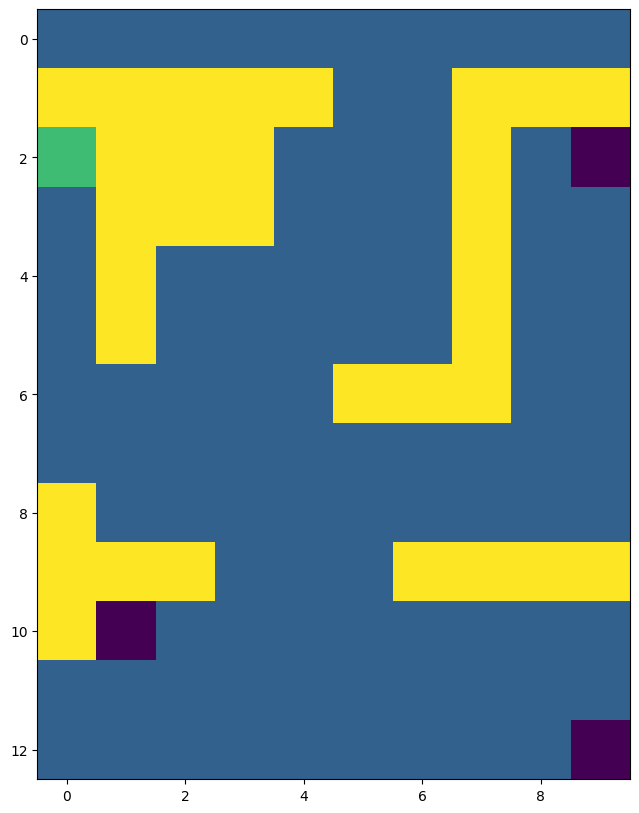

Results of the DP agent:



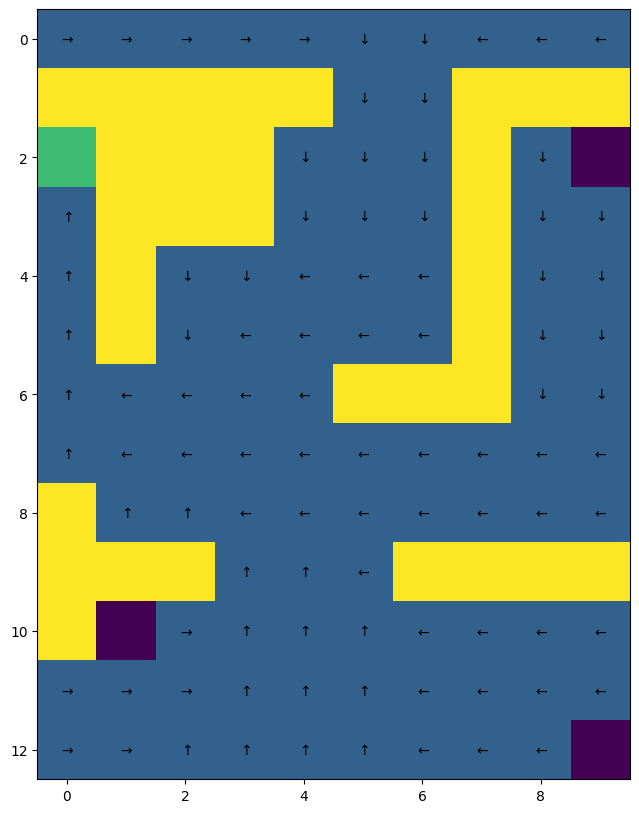

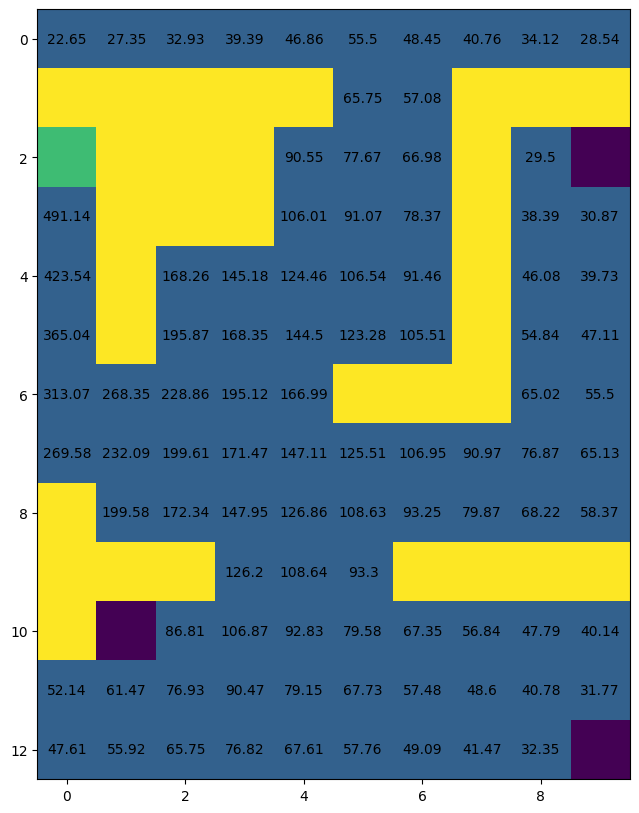

In [6]:
### Question 1: Dynamic programming
np.random.seed(0)
random.seed(0)

maze = Maze()

dp_agent = DP_agent()
dp_policy, dp_value = dp_agent.solve(maze)

print("Results of the DP agent:\n")
maze.get_graphics().draw_policy(dp_policy)
maze.get_graphics().draw_value(dp_value)

## MC AGENT

In [7]:
# This class define the Monte-Carlo agent

class MC_agent(object):
  
  def generate_episode(self, policy, env):
    #action from policy
    actions = [action for action in range(env.get_action_size())]
    episode = []
    
    t_0, s_0, r_0, is_terminal = env.reset()
    a_0 = np.random.choice(actions, 1, p=policy[s_0, :])[0]
    initial = { 
      "time_step":t_0, 
      "state": s_0, 
      "reward":r_0, 
      "action":a_0, 
      "is_terminal": is_terminal
      }
    episode.append(initial)

    while not is_terminal: 
      
      last_location = episode[-1]
      t, state_t, reward_t, is_terminal = env.step(last_location["action"])
      action_t = np.random.choice(actions, 1, p=policy[state_t, :])[0]
      
      info_t = { 
        "time_step":t,
        "state": state_t, 
        "reward":reward_t, 
        "action":action_t, 
        "is_terminal": is_terminal
        }

      episode.append(info_t)
      del info_t

    return episode
  
  def update_policy_e_greedy(self, policy, episode, Q, e, env):
    
    action_size = env.get_action_size()
    
    for state in [step["state"] for step in episode]:
      a_star = np.argmax(Q[state, :])
      for action in range(action_size):
        if a_star == action:
          policy[state, action] = 1 - e + (e/action_size)
        else:
          policy[state, action] = e/action_size

    return policy
  
  def mc_method_on_policy(self, Q, V, values, total_rewards, total_episodes, e, gamma, alpha, env, decaying_e=True, verbose=False):
    
    count_s = np.zeros(env.get_state_size())
    count_s_a = np.zeros((env.get_state_size(), env.get_action_size())) 
    policy = np.zeros((env.get_state_size(), env.get_action_size())) + 0.25 
    
    if decaying_e:
      original_e = e

    for ep in range(total_episodes):
    
      if ep%1000 == 0 and verbose:
        print(f"Episode:{ep}")

      G = 0
      non_discounted_G = 0
      V = values[-1].copy()
      episode = self.generate_episode(policy, env)
      
      for i, step in enumerate(episode[::-1][1:]):
        
        state_t, action_t, reward_t_1 = step["state"], step["action"], episode[::-1][i]["reward"]
        count_s[state_t] += 1
        count_s_a[state_t, action_t] += 1

        G = (gamma * G) + reward_t_1
        non_discounted_G += reward_t_1

        Q[state_t, action_t] += (G - Q[state_t, action_t])/count_s_a[state_t, action_t]
        V[state_t] += (G - V[state_t])/count_s[state_t]
      
      if decaying_e:
        e = original_e - (ep/total_episodes)*original_e
      
      policy = self.update_policy_e_greedy(policy, episode, Q, e, env)
      total_rewards.append(non_discounted_G)
      values.append(V)

      del G, non_discounted_G, episode, V
    
    return policy, values, total_rewards, Q

  def mc_method_on_policy_alpha(self, Q, V, values, total_rewards, total_episodes, e, gamma, alpha, env, verbose=False):
    
    count_s = np.zeros(env.get_state_size())
    policy = np.zeros((env.get_state_size(), env.get_action_size())) + 0.25

    for ep in range(total_episodes):
    
      if ep%1000 == 0 and verbose:
        print(f"Episode:{ep}")

      episode = self.generate_episode(policy, env)
      G = 0
      non_discounted_G = 0
      V = values[-1].copy()
      
      for i, step in enumerate(episode[::-1][1:]):
        
        state_t, action_t, reward_t_1 = step["state"], step["action"], episode[::-1][i]["reward"]
        count_s[state_t] += 1

        G = (gamma * G) + reward_t_1
        non_discounted_G += reward_t_1

        Q[state_t, action_t] += (alpha * (G - Q[state_t, action_t]))
        V[state_t] += (G - V[state_t])/count_s[state_t]
      
      policy = self.update_policy_e_greedy(policy, episode, Q, e, env)
      total_rewards.append(non_discounted_G)
      values.append(V)

      del G, non_discounted_G, episode, V
        
    return policy, values, total_rewards, Q
  
  def solve_with_custom_params(self, total_episodes, e, alpha, env, is_alpha, verbose=False, decaying_e=False):
    Q = np.random.rand(env.get_state_size(), env.get_action_size()) 
    V = np.zeros(env.get_state_size())
    gamma = env.get_gamma()
    values = [V]
    total_rewards = []

    if is_alpha:
      policy, values, total_rewards, _ = self.mc_method_on_policy_alpha(Q, V, values, total_rewards, total_episodes, e, gamma, alpha, env, verbose)

    else:
      policy, values, total_rewards, _ = self.mc_method_on_policy(Q, V, values, total_rewards, total_episodes, e, gamma, alpha, env, decaying_e, verbose)
      
    return policy, values, total_rewards  
  
  # WARNING: make sure this function can be called by the auto-marking script
  def solve(self, env):
    """
    Solve a given Maze environment using Monte Carlo learning
    input: env {Maze object} -- Maze to solve
    output: 
      - policy {np.array} -- Optimal policy found to solve the given Maze environment 
      - values {list of np.array} -- List of successive value functions for each episode 
      - total_rewards {list of float} -- Corresponding list of successive total non-discounted sum of reward for each episode 
    """
    # Initialisation (can be edited)
    Q = np.random.rand(env.get_state_size(), env.get_action_size()) 
    V = np.zeros(env.get_state_size())
    gamma = env.get_gamma()
    values = [V]
    total_rewards = []

    total_episodes = 5000
    e = 0.4
    alpha = 0.05
    decaying_e = True

    policy, values, total_rewards, _ = self.mc_method_on_policy(Q, V, values, total_rewards, total_episodes, e, gamma, alpha, env, decaying_e=decaying_e)
    
    return policy, values, total_rewards

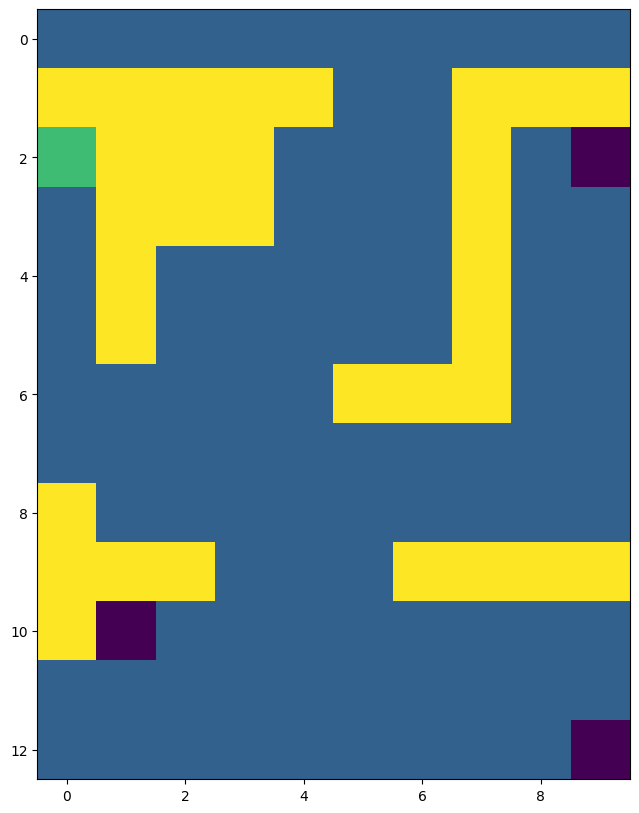

Results of the MC agent:



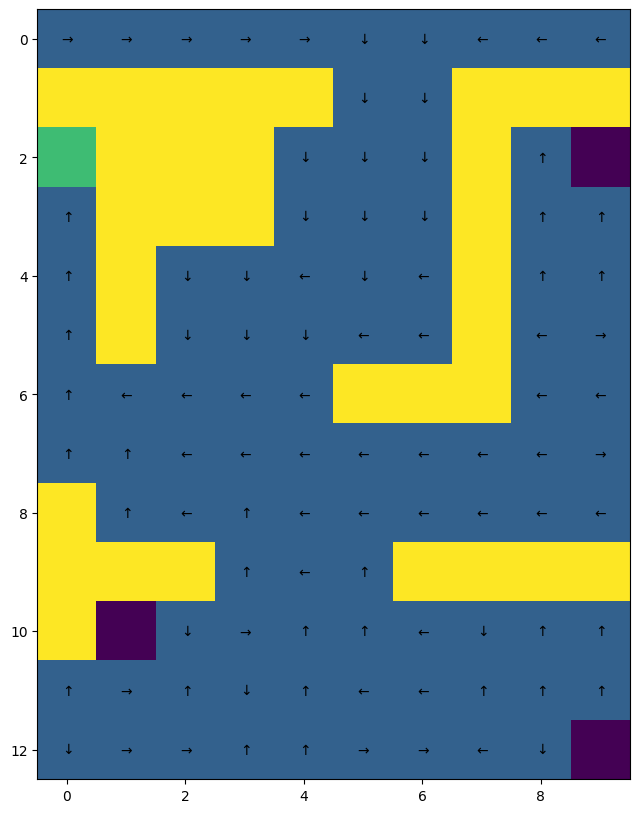

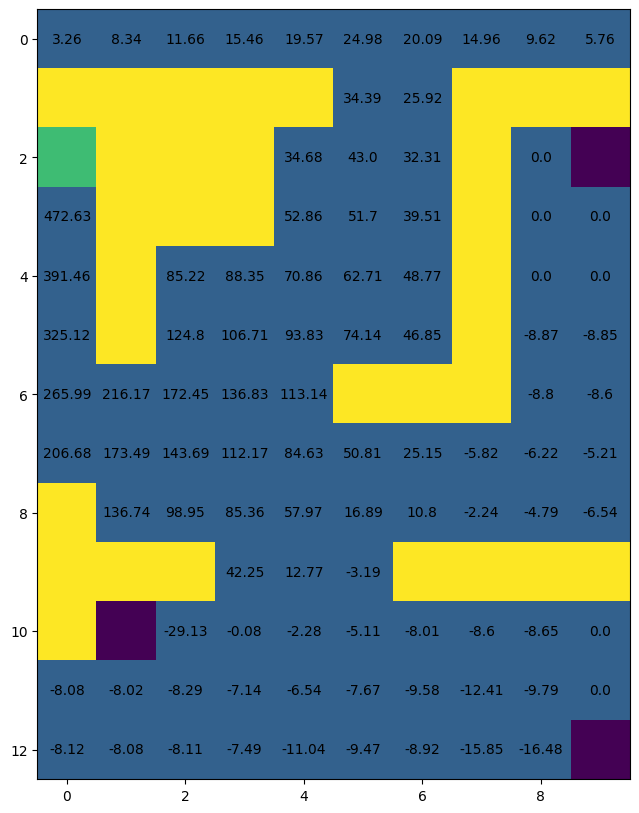

In [8]:
### Question 2: Monte-Carlo learning
np.random.seed(0)
random.seed(0)

maze = Maze()

mc_agent = MC_agent()
mc_policy, mc_values, total_rewards = mc_agent.solve(maze)

print("Results of the MC agent:\n")
maze.get_graphics().draw_policy(mc_policy)
maze.get_graphics().draw_value(mc_values[-1])

## TD agent

In [9]:
# This class define the Temporal-Difference agent

class TD_agent(object):

  def action_policy_e_greedy(self, Q, state, e, env):
    
    action_size = env.get_action_size()
    actions = [action for action in range(action_size)]
    a_star = np.argmax(Q[state, :])
    rand_int = np.random.rand(1)[0]
    
    if rand_int < 1 - e + (e/action_size):
      return a_star
    else:
      other_actions = [a for a in actions if a !=a_star]
      return np.random.choice(other_actions, 1, p=[1/3, 1/3,1/3])[0]

  def get_greedy_policy(self, Q, policy, env):
    states = env.get_state_size()
    for s in range(states):
      a_star = np.argmax(Q[s, :])
      policy[s,a_star] = 1
    return policy

  
  def sarsa(self, Q, V, values, total_rewards, total_episodes, e, gamma, alpha, env):

    original_e = e

    for ep in range(total_episodes):
      
      G = 0
      V = values[-1].copy()
      _, state_t, _, is_terminal = env.reset()

      while not is_terminal:
          
        action_t = self.action_policy_e_greedy(Q, state_t, e, env)
        _, state_t_1, reward_t_1, is_terminal = env.step(action_t)
        a_t_1 = self.action_policy_e_greedy(Q, state_t_1, e, env)

        Q[state_t, action_t] += alpha * (reward_t_1 - Q[state_t, action_t] + gamma * Q[state_t_1, a_t_1])
        V[state_t] += alpha * (reward_t_1 - V[state_t] + gamma * V[state_t_1])
        
        G += reward_t_1
        state_t = state_t_1

      e = original_e - (ep/total_episodes)*original_e
      
      total_rewards.append(G)
      values.append(V)

    policy = np.zeros((env.get_state_size(), env.get_action_size())) 
    policy = self.get_greedy_policy(Q, policy, env)
    
    return policy, values, total_rewards  

  def q_learning(self, Q, V, values, total_rewards, total_episodes, e, gamma, alpha, env):

      for _ in range(total_episodes):
        
        G = 0
        V = values[-1].copy()
        _, state_t, _, is_terminal = env.reset()

        while not is_terminal:
            
          action_t = self.action_policy_e_greedy(Q, state_t, e, env)
          _, state_t_1, reward_t_1, is_terminal = env.step(action_t)

          Q[state_t, action_t] += alpha * (reward_t_1 - Q[state_t, action_t] + gamma * max(Q[state_t_1, :]) )
          V[state_t] += alpha * (reward_t_1 - V[state_t] + gamma * V[state_t_1])
          
          G += reward_t_1
          state_t = state_t_1
        
        total_rewards.append(G)
        values.append(V)

      policy = np.zeros((env.get_state_size(), env.get_action_size())) 
      policy = self.get_greedy_policy(Q, policy, env)
      
      return policy, values, total_rewards 
  
  def solve_with_custom_params(self, total_episodes, e, alpha, env):
    Q = np.random.rand(env.get_state_size(), env.get_action_size()) 
    V = np.zeros(env.get_state_size())
    gamma = env.get_gamma()
    values = [V]
    total_rewards = []

    policy, values, total_rewards = self.q_learning(Q, V, values, total_rewards, total_episodes, e, gamma, alpha, env)
      
    return policy, values, total_rewards  
    
  # WARNING: make sure this function can be called by the auto-marking script
  def solve(self, env):
    """
    Solve a given Maze environment using Temporal Difference learning
    input: env {Maze object} -- Maze to solve
    output: 
      - policy {np.array} -- Optimal policy found to solve the given Maze environment 
      - values {list of np.array} -- List of successive value functions for each episode 
      - total_rewards {list of float} -- Corresponding list of successive total non-discounted sum of reward for each episode 
    """
    Q = np.random.rand(env.get_state_size(), env.get_action_size()) 
    V = np.zeros(env.get_state_size())
    gamma = env.get_gamma()
    values = [V]
    total_rewards = []

    total_episodes = 1000
    alpha = 0.4
    e = 0.2

    policy, values, total_rewards = self.q_learning(Q, V, values, total_rewards, total_episodes, e, gamma, alpha, env)

    return policy, values, total_rewards

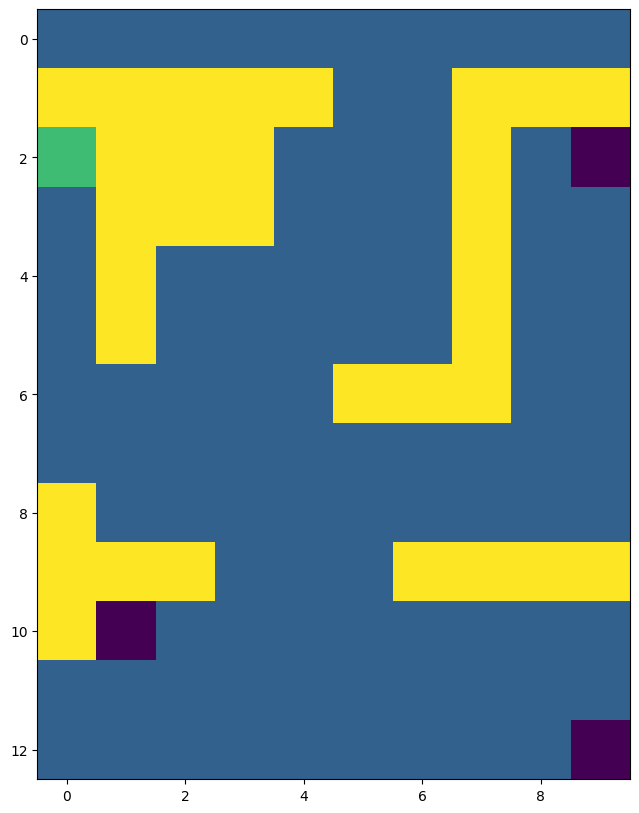

Results of the TD agent:



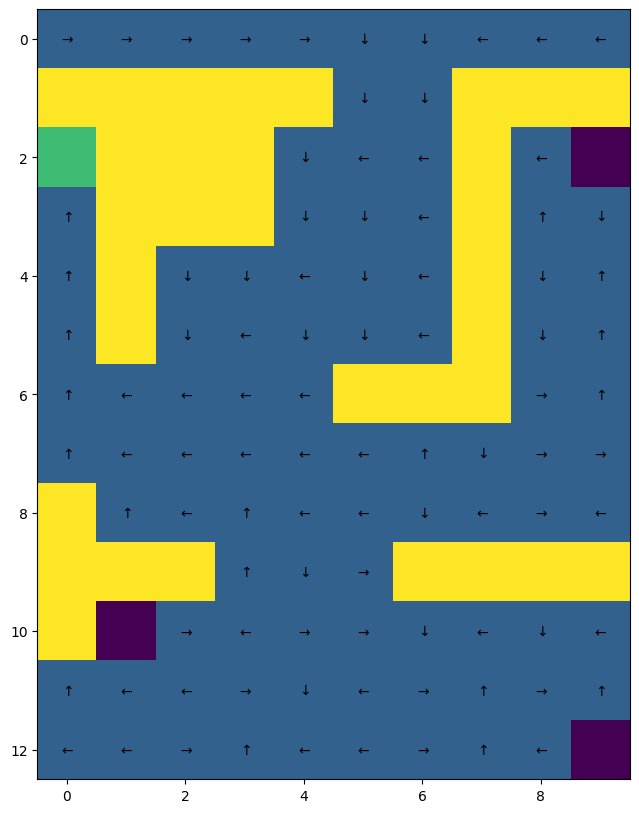

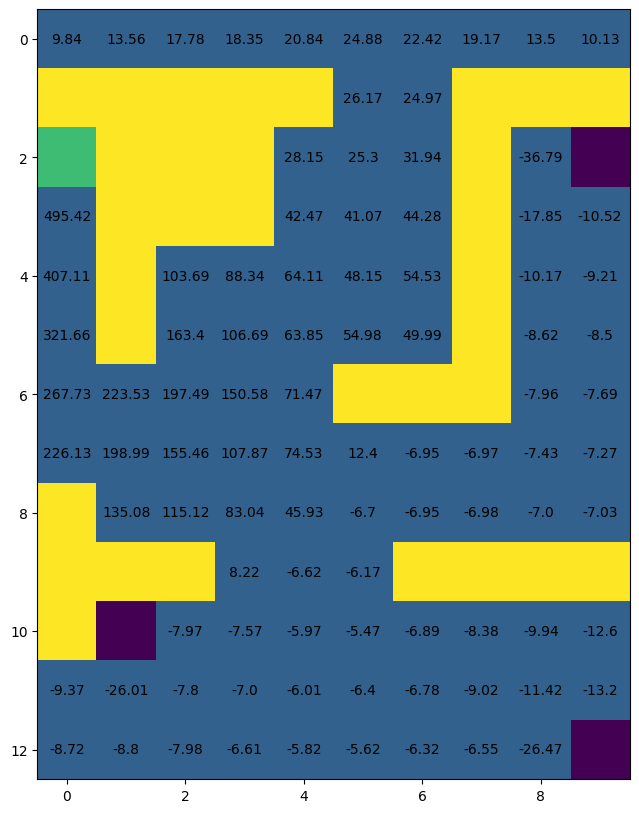

In [10]:
### Question 3: Temporal-Difference learning
np.random.seed(0)
random.seed(0)

maze = Maze()

td_agent = TD_agent()
td_policy, td_values, total_rewards = td_agent.solve(maze)

print("Results of the TD agent:\n")
maze.get_graphics().draw_policy(td_policy)
maze.get_graphics().draw_value(td_values[-1])

In [11]:
def msqe_v_one_run(V, V_baseline):

    all_msqe = []
    for i in range(len(np.array(V))):

        all_msqe.append(mean_squared_error(np.array(V[i]), np.array(V_baseline)))   

    return all_msqe

In [12]:
def compare_methods_V(env, n_runs, total_episodes, V_baseline):

    e_td, alpha_td = 0.2, 0.4
    e_mc, alpha_mc = 0.4, 0.05

    msqe_mc_all_runs, msqe_td_all_runs, rewards_mc, rewards_td = [], [], [], []

    for n in range(n_runs):

        print(f"Run:{n}")

        mc_agent = MC_agent()
        td_agent = TD_agent()

        _, mc_values, mc_total_rewards = mc_agent.solve_with_custom_params(total_episodes, e_mc, alpha_mc, env, is_alpha=False, decaying_e=True)
        _, td_values, td_total_rewards = td_agent.solve_with_custom_params(total_episodes, e_td, alpha_td, env)
        
        td_msqe, mc_msqe = msqe_v_one_run(td_values, V_baseline), msqe_v_one_run(mc_values, V_baseline)
        msqe_mc_all_runs.append(mc_msqe)
        msqe_td_all_runs.append(td_msqe)
        rewards_mc.append(mc_total_rewards)
        rewards_td.append(td_total_rewards)

    return msqe_mc_all_runs, msqe_td_all_runs, rewards_mc, rewards_td

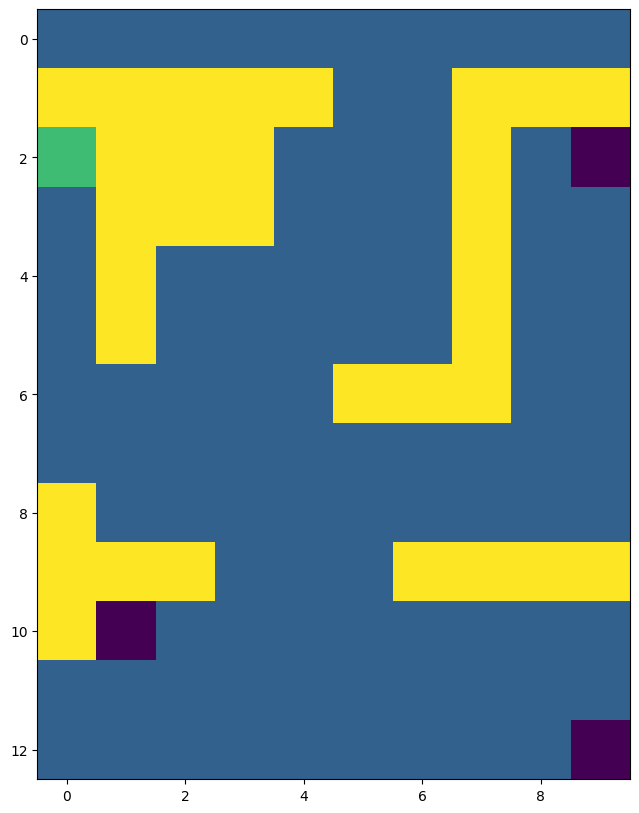

Run:0
Run:1
Run:2
Run:3
Run:4
Run:5
Run:6
Run:7
Run:8
Run:9
Run:10
Run:11
Run:12
Run:13
Run:14
Run:15
Run:16
Run:17
Run:18
Run:19
Run:20
Run:21
Run:22
Run:23
Run:24


In [13]:
np.random.seed(1)
random.seed(1)

env = Maze()
msqe_mc_all_runs, msqe_td_all_runs, rewards_mc, rewards_td = compare_methods_V(env, 25, 5000, dp_value)

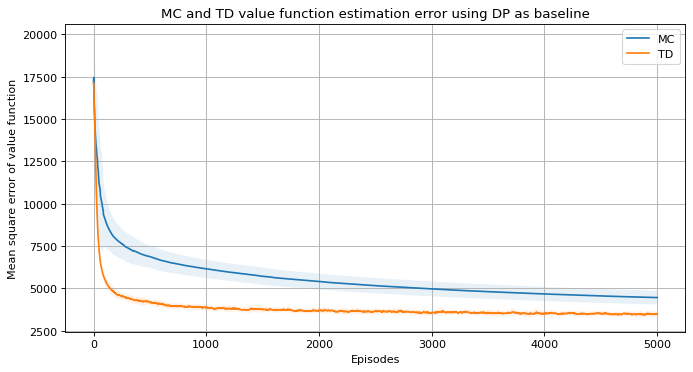

In [14]:
mean_reward_mc = np.mean(msqe_mc_all_runs, axis=0) 
std_reward_mc = np.sqrt(np.var(msqe_mc_all_runs, axis=0))

mean_reward_td = np.mean(msqe_td_all_runs, axis=0) 
std_reward_td = np.sqrt(np.var(msqe_td_all_runs, axis=0))

plt.figure(figsize=(10, 5), dpi=80)

plt.plot([i for i in range(5001)],mean_reward_mc, label="MC")
plt.fill_between([i for i in range(5001)], (mean_reward_mc-std_reward_mc), (mean_reward_mc+std_reward_mc), alpha=.1)

plt.plot([i for i in range(5001)],mean_reward_td, label="TD")
plt.fill_between([i for i in range(5001)], (mean_reward_td-std_reward_td), (mean_reward_td+std_reward_td), alpha=.1)

plt.ylabel('Mean square error of value function')
plt.xlabel('Episodes')
plt.title('MC and TD value function estimation error using DP as baseline')
plt.legend(loc='upper right')
plt.grid()

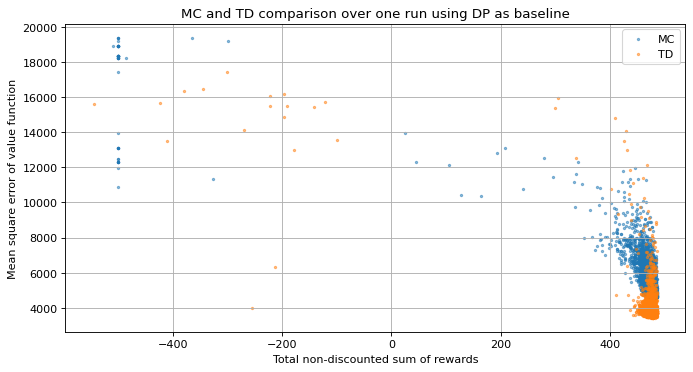

In [16]:
msqe_mc_all_runs[-1], msqe_td_all_runs[-1], rewards_mc[-1], rewards_td[-1]

plt.figure(figsize=(10, 5), dpi=80)


plt.title('MC and TD comparison over one run using DP as baseline')
plt.scatter(rewards_mc[-1], msqe_mc_all_runs[-1][1:], label="MC", s=4, alpha=0.5)
plt.scatter(rewards_td[-1], msqe_td_all_runs[-1][1:], label="TD", s=4, alpha=0.5)

plt.xlabel('Total non-discounted sum of rewards')
plt.ylabel('Mean square error of value function')

plt.legend(loc='upper right')
plt.grid()

## Example main

Creating the Maze:



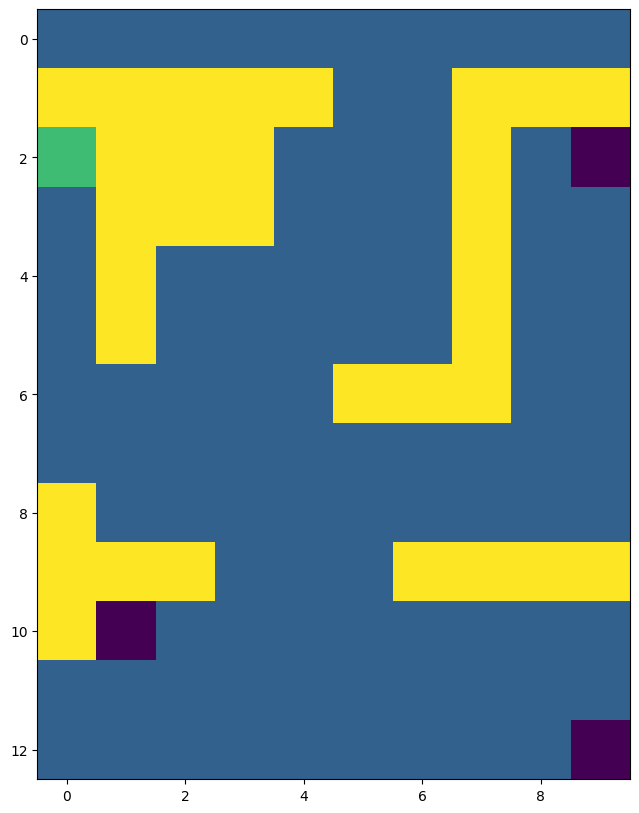

Results of the DP agent:



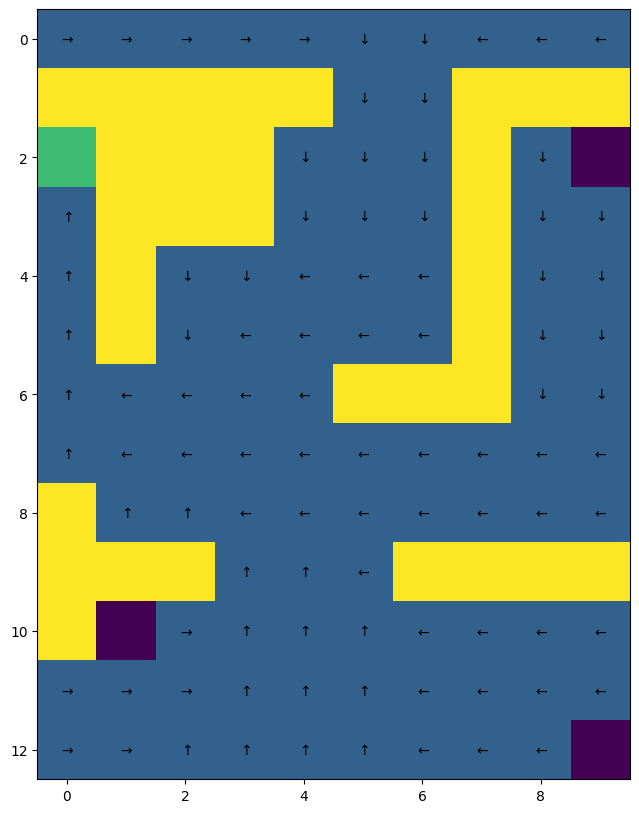

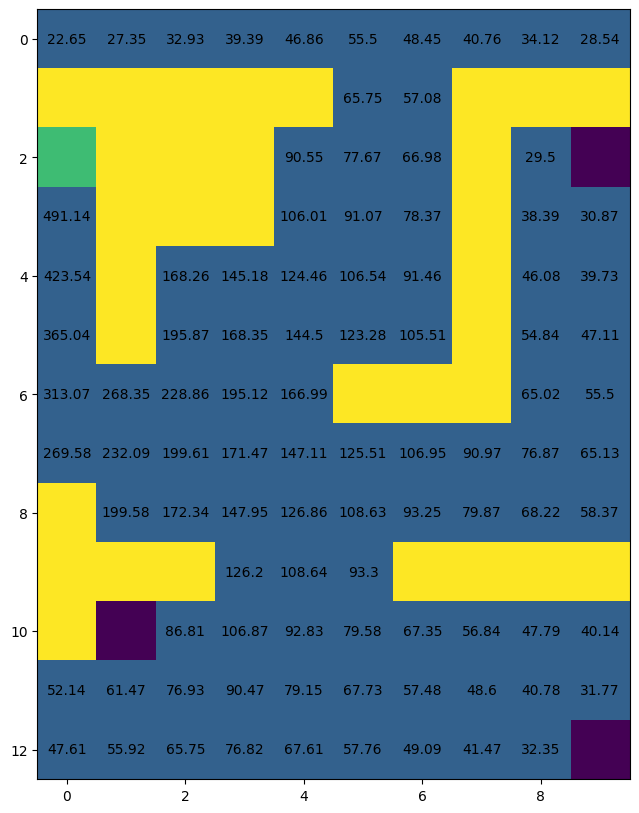

Results of the MC agent:



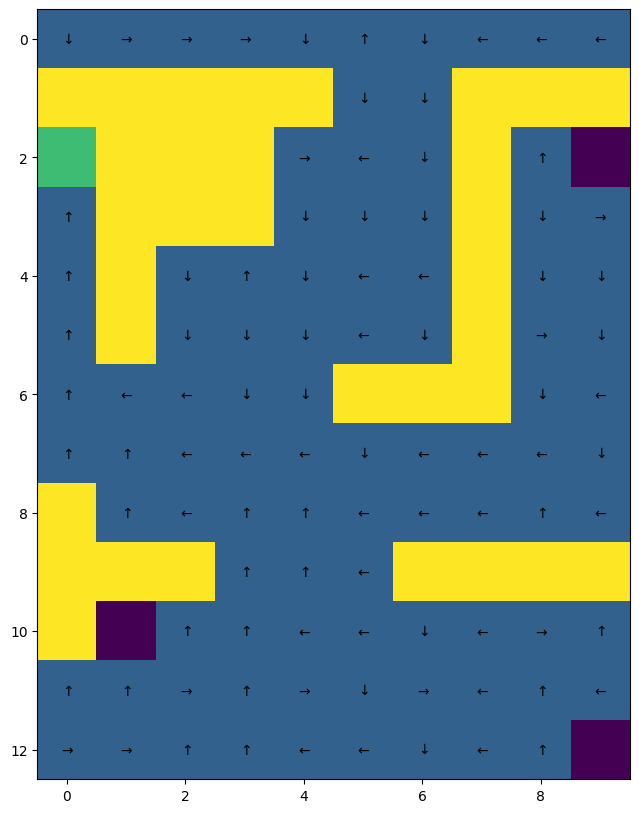

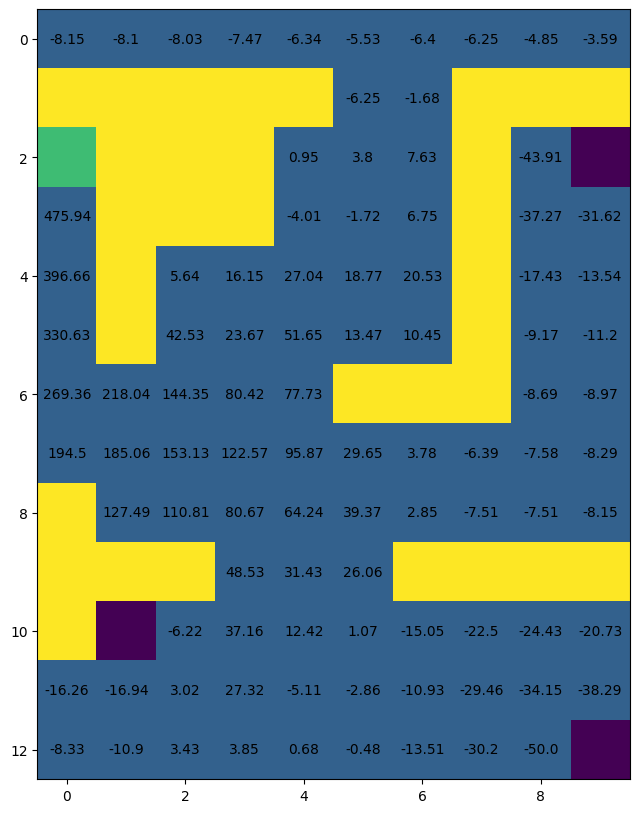

Results of the TD agent:



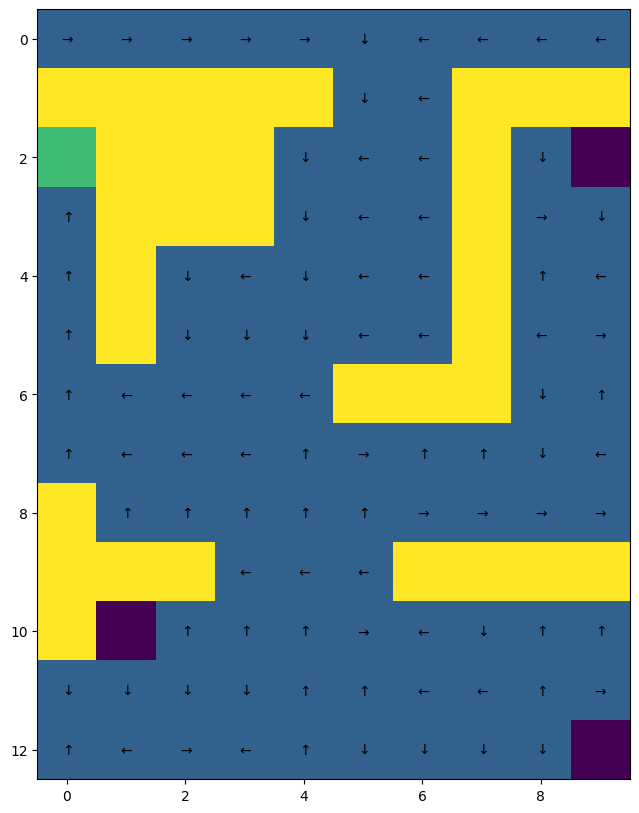

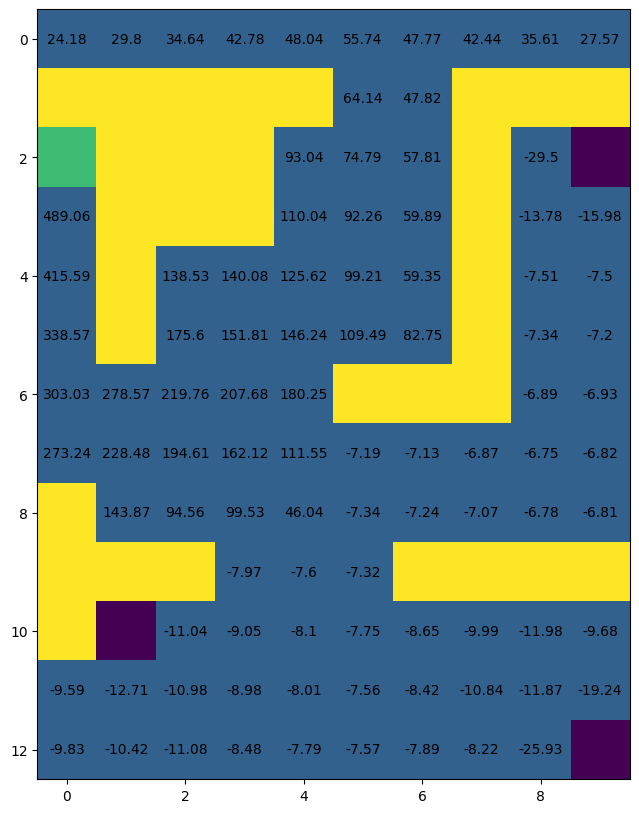

In [16]:
# Example main (can be edited)

### Question 0: Defining the environment

print("Creating the Maze:\n")
maze = Maze()


### Question 1: Dynamic programming

dp_agent = DP_agent()
dp_policy, dp_value = dp_agent.solve(maze)

print("Results of the DP agent:\n")
maze.get_graphics().draw_policy(dp_policy)
maze.get_graphics().draw_value(dp_value)


### Question 2: Monte-Carlo learning

mc_agent = MC_agent()
mc_policy, mc_values, total_rewards = mc_agent.solve(maze)

print("Results of the MC agent:\n")
maze.get_graphics().draw_policy(mc_policy)
maze.get_graphics().draw_value(mc_values[-1])


### Question 3: Temporal-Difference learning

td_agent = TD_agent()
td_policy, td_values, total_rewards = td_agent.solve(maze)

print("Results of the TD agent:\n")
maze.get_graphics().draw_policy(td_policy)
maze.get_graphics().draw_value(td_values[-1])